Extract feature vectors from image corpus using tfhub models

Author: Christopher Pietsch

In [5]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tensorflow_hub as hub

import pandas as pd
import os

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.3.0
The following GPU devices are available: /device:GPU:0


In [11]:
model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r152x4/1")

Alternative models

In [ ]:
model = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4", trainable=False)

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4", trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(512, activation='softmax')
])
model.build([None, 299, 299, 3])  # Batch input shape.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
_________________________________________________________________
dense (Dense)                multiple                  1049088   
Total params: 22,851,872
Trainable params: 1,049,088
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4", trainable=False)

In [ ]:
model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x3/1")

Import Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy CSV data from drive

In [ ]:
!rm -fr csv
!mkdir csv
%cp -rd /content/drive/My\ Drive/SMB/Daten/clean/* csv/

Copy and extract images from drive

In [3]:
!rm -frd images
!mkdir images
%cp /content/drive/My\ Drive/SMB/Daten/crop.zip /content/images/
!unzip -q /content/images/crop.zip -d /

Get a list of all images

In [12]:
list_ds = tf.data.Dataset.list_files("/content/crop/**/*.jpg")
for f in list_ds.take(5):
  print(f.numpy())

b'/content/crop/mek/1877185.jpg'
b'/content/crop/mek/1443105.jpg'
b'/content/crop/mek/515275.jpg'
b'/content/crop/mek/1722445.jpg'
b'/content/crop/ang/2260098.jpg'


Load images with desired batch size

In [80]:
BATCHSIZE = 10

def load_img(path):
  parts = tf.strings.split(path, os.path.sep)
  parts2 = tf.strings.split(parts[-1], ".")
  label = parts2[0]
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)
  resized = tf.image.resize(converted_img, [400,400], antialias=True)

  return resized, label, path

def prepare_for_training(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.batch(BATCHSIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [81]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds = list_ds.map(load_img, num_parallel_calls=AUTOTUNE)
ds = prepare_for_training(ds)

for image, label, path in ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("id", label.numpy())
  #print("paths", path.numpy())

Image shape:  (4, 800, 800, 3)
id [b'2307796' b'1128004' b'515048' b'1520046']


Check the batch

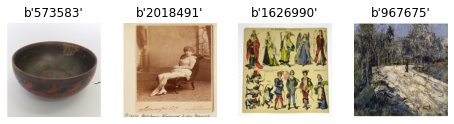

In [83]:
import IPython.display as display

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCHSIZE):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(np.uint8(image_batch[n]*255))
      plt.title(label_batch[n])
      plt.axis('off')

image_batch, label_batch, path_batch = next(iter(ds))
show_batch(image_batch.numpy(), label_batch.numpy())

RUN the model with dataset in batch mode and store normalized feature vectors

In [ ]:
from numpy.linalg import norm

embeds = []
embeds_norm = []
embeds_norm2 = []
ids = []
paths = []

#for image_batch, label_batch, path_batch in ds.take(1):
for image_batch, label_batch, path_batch in ds:
  print(".",end='')
  embeds_batch = model(image_batch)
  normalized = tf.math.l2_normalize(embeds_batch, axis = 1)
  embeds.extend(embeds_batch.numpy())
  embeds_norm.extend(normalized.numpy())
  
  ids.extend(label_batch.numpy())
  paths.extend(path_batch.numpy())

  """
  print(embeds)
  print(np.inner(embeds, embeds))
  cosine2 = np.inner(embeds, embeds) / (norm(embeds) * norm(embeds))
  cosine_loss(embeds, embeds).numpy()
  print(cosine)
  print(cosine2)
  cosine = tf.keras.losses.cosine_similarity(normed, normed, axis=0).numpy()
  print(cosine.shape)
  normed = tf.nn.l2_normalize(embeds, 0)
  print(normed)
  
  """

print(len(ids))
ids = [id.decode() for id in ids]
paths = [path.decode() for path in paths]

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Convert embeddings into numpy array

In [1]:
corr = np.inner(embeds_norm, embeds_norm)
corr

NameError: ignored

Optional: store embeds as pickle

In [ ]:
print(len(embeds[0]))
import pickle
import bz2
pickle.dump([embeds_norm, embeds, ids], open('features-bit-m-r152x4.p', 'wb'))
%cp features-bit-m-r152x4.p /content/drive/My\ Drive/SMB/Daten/clean/

8192


In [15]:
def arr_to_csv(arr, filename, mult=10000):
  dataframe = (pd.DataFrame(arr) * mult).round(0).astype('int32')
  dataframe['id'] = ids
  dataframe.to_csv(filename)
  return dataframe

Store raw feature vectors into a csv and keep the filesize handable

In [16]:
dataframe = arr_to_csv(embeds_norm, "bit8192.csv")
dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191,id
0,0,0,0,7,56,6,13,6,244,72,0,37,1,8,3,34,0,107,78,27,1,120,204,23,14,33,27,0,0,30,32,0,14,222,10,30,1,11,1,0,...,4,31,45,0,6,22,87,123,0,222,44,21,4,339,1,0,2,0,231,6,0,41,631,0,45,0,313,10,449,0,1,346,0,0,199,3,12,4,0,1486397
1,0,0,0,62,163,1,41,24,22,45,1,6,5,1,16,45,0,15,6,155,2,64,71,1,4,8,4,1,0,85,20,7,0,91,1,4,22,210,12,2,...,3,117,86,0,17,28,25,60,3,7,36,13,0,404,55,0,23,0,81,97,40,200,372,42,45,1,77,2,94,1,4,25,0,2,27,21,13,69,0,1570538
2,0,0,0,36,71,0,341,14,0,0,9,2,46,0,4,47,0,108,13,178,0,122,5,0,2,25,10,3,0,47,19,19,0,122,0,0,78,14,2,7,...,5,2,3,0,9,75,122,47,0,0,6,76,8,108,23,0,0,0,49,3,30,6,292,0,74,0,220,10,405,1,0,213,0,2,64,60,10,119,0,525580
3,0,0,0,20,15,0,575,5,0,28,0,10,24,2,45,7,0,0,3,87,26,157,2,0,35,1,1,4,0,9,6,8,0,222,1,3,33,7,3,13,...,0,59,7,0,6,12,65,48,2,23,30,1,355,116,25,0,3,0,172,153,19,479,238,0,167,0,117,8,269,1,2,8,0,0,194,1,0,463,0,1442848
4,0,0,0,53,19,1,202,2,7,0,1,27,8,3,29,19,0,492,0,63,3,303,177,2,4,8,28,11,0,33,0,4,13,41,2,0,47,12,2,7,...,2,14,0,0,35,51,16,4,0,85,17,10,1,4,134,3,0,3,52,1,49,66,270,1,35,0,461,5,101,6,7,11,0,0,46,3,27,12,0,962622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,0,0,0,33,69,0,623,4,34,3,0,0,22,0,4,70,0,147,77,189,1,303,5,0,0,21,53,7,0,72,4,10,0,290,0,0,150,108,63,24,...,9,52,52,0,25,3,100,8,0,11,37,18,0,226,10,1,73,0,266,15,29,89,337,58,28,0,113,48,309,6,29,102,1,0,1,30,10,67,0,984816
5136,0,0,1,7,7,1,313,3,9,5,8,2,5,2,66,0,0,42,21,46,9,485,31,1,31,9,6,20,0,182,16,20,0,206,2,4,40,107,0,22,...,10,31,99,0,27,65,101,138,0,206,66,50,92,29,25,11,146,0,246,23,36,10,85,5,269,0,33,12,223,4,13,58,1,1,287,1,5,99,0,1479834
5137,0,0,0,15,11,0,404,1,50,4,3,1,9,0,1,41,0,71,14,55,0,345,253,1,21,75,0,3,0,244,35,3,0,196,0,6,14,157,31,0,...,1,123,2,0,7,73,31,311,0,27,52,29,98,213,18,2,0,0,65,24,3,210,229,3,26,0,34,16,169,0,25,24,0,0,265,25,5,197,0,961858
5138,0,0,0,81,147,1,1,17,0,92,0,18,0,25,15,6,0,89,79,32,3,71,273,0,16,6,28,9,0,32,12,2,0,40,7,4,126,231,7,1,...,84,105,218,0,0,189,46,418,0,119,16,25,34,153,25,0,13,0,479,1,56,245,567,0,27,0,48,0,207,0,0,123,0,0,249,0,5,326,0,564288


Calculate the inner product in order to get the distances of each image to another

In [17]:
from sklearn import preprocessing

corr = np.inner(embeds_norm, embeds_norm)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(corr)
corrDf = pd.DataFrame(x_scaled)
corrDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119,5120,5121,5122,5123,5124,5125,5126,5127,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5139
0,1.000000,0.457290,0.326567,0.339461,0.266783,0.287822,0.275338,0.178412,0.476937,0.247725,0.266889,0.322321,0.304906,0.302354,0.308502,0.254841,0.288952,0.281187,0.215991,0.269741,0.405225,0.261289,0.242384,0.179054,0.375515,0.405239,0.284460,0.306997,0.232834,0.292147,0.294860,0.214119,0.313668,0.203439,0.268565,0.369638,0.216738,0.234221,0.293703,0.335490,...,0.316022,0.424735,0.257708,0.261009,0.409635,0.273292,0.392208,0.390441,0.215901,0.356504,0.243533,0.306577,0.255105,0.317930,0.241446,0.292149,0.422240,0.371469,0.277302,0.277945,0.324981,0.264071,0.302169,0.257366,0.277096,0.278765,0.268862,0.270736,0.259198,0.309810,0.235111,0.377513,0.289537,0.205200,0.190774,0.332730,0.310637,0.273380,0.211410,0.336968
1,0.419003,1.000000,0.521651,0.563000,0.393276,0.461824,0.514276,0.312839,0.656209,0.389151,0.602347,0.499241,0.462091,0.506954,0.487057,0.313093,0.436363,0.326982,0.431038,0.339905,0.571784,0.426348,0.482604,0.294095,0.444472,0.490153,0.365757,0.441634,0.324219,0.480436,0.530850,0.279712,0.478256,0.305539,0.454683,0.543962,0.347196,0.414887,0.524066,0.425601,...,0.459604,0.583123,0.352426,0.381678,0.427031,0.433737,0.457441,0.604993,0.308836,0.448638,0.386174,0.480335,0.352647,0.475168,0.329901,0.411922,0.591348,0.448194,0.479519,0.399569,0.540288,0.333342,0.343307,0.362739,0.352938,0.453597,0.337291,0.461218,0.354756,0.370976,0.313607,0.519948,0.419773,0.364785,0.209338,0.538237,0.379075,0.532424,0.284158,0.407403
2,0.264365,0.511901,1.000000,0.500683,0.347956,0.362289,0.341059,0.214918,0.624596,0.375373,0.412618,0.337103,0.355519,0.426002,0.385456,0.174648,0.337698,0.191645,0.261193,0.232471,0.455677,0.351172,0.347147,0.278898,0.509762,0.472753,0.284975,0.310653,0.332254,0.352891,0.355771,0.243990,0.456929,0.251010,0.360744,0.383820,0.230421,0.270942,0.371218,0.385066,...,0.629458,0.462268,0.309084,0.296553,0.401573,0.340904,0.421767,0.401722,0.205121,0.371293,0.268961,0.309431,0.250740,0.284734,0.316220,0.310289,0.583554,0.446302,0.455238,0.319966,0.347170,0.198457,0.335685,0.361620,0.353290,0.359488,0.313272,0.299571,0.304054,0.355113,0.328140,0.338890,0.375086,0.321544,0.109284,0.652300,0.383889,0.302176,0.202753,0.353938
3,0.239447,0.529990,0.473693,1.000000,0.436038,0.469482,0.407316,0.274694,0.522584,0.412285,0.455930,0.549375,0.527956,0.698380,0.552413,0.205932,0.477054,0.229559,0.303748,0.319513,0.454637,0.432312,0.421491,0.298825,0.491161,0.491936,0.407122,0.454899,0.411369,0.408466,0.394550,0.305563,0.510059,0.307294,0.514792,0.575866,0.322563,0.290711,0.628843,0.551613,...,0.434126,0.450489,0.454612,0.385092,0.433668,0.455079,0.534435,0.424309,0.288491,0.608222,0.426614,0.459245,0.375017,0.406357,0.397499,0.361095,0.509812,0.539383,0.536118,0.429500,0.408003,0.215719,0.493171,0.353680,0.261132,0.500629,0.339505,0.402039,0.416150,0.515959,0.338993,0.481168,0.551943,0.310429,0.191511,0.447135,0.506444,0.472648,0.225443,0.549180
4,0.183485,0.368872,0.335277,0.454556,1.000000,0.438593,0.433406,0.274050,0.390656,0.341656,0.449561,0.478605,0.318255,0.383599,0.507119,0.224318,0.615927,0.267610,0.265543,0.226804,0.445242,0.644203,0.416709,0.224789,0.388101,0.339735,0.297798,0.299127,0.616453,0.361186,0.433662,0.246604,0.349841,0.304164,0.552972,0.347114,0.285949,0.422890,0.459980,0.387195,...,0.317869,0.340567,0.498790,0.556050,0.274337,0.495643,0.321223,0.433700,0.273090,0.372049,0.278786,0.304690,0.313884,0.410999,0.636392,0.529093,0.326178,0.401997,0.459031,0.516710,0.352271,0.243143,0.358711,0.263574,0.226354,0.481741,0.230371,0.275949,0.273066,0.363141,0.246621,0.475848,0.671662,0.218918,0.196497,0.336128,0.368404,0.426573,0.193772,0.353042
...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [20]:
corrDfRaw = pd.DataFrame(corr)

Now we can check the distances for an id and display the results. First we get all distances sorted for one object.

In [26]:
id = '1717261' #@param {type:"string"}
index = ids.index(id)
row = pd.DataFrame(ids, columns=['id'])
row['corr'] = corrDf[index]
sortedDf = row.sort_values(by=['corr'], ascending=False)
sortedDf

,id,corr
3968,1717261,1.000000
3204,1603925,0.703118
571,963112,0.702442
906,1573513,0.690992
93,1835625,0.667010
...,...,...
2535,961181,0.007223
257,960264,0.007223
4277,1816466,0.007223
2546,959158,0.000000


Display the list as images inline

In [22]:
from IPython.display import HTML
html = ""

for item in sortedDf.values.tolist()[:20]:
  url = "https://vikusviewer.fh-potsdam.de/smb/beide/data/1024/"+str(item[0])+".jpg"
  image = '<img src="{}" width="100">'.format(url)
  html += image

HTML(html)

Calculate and display the correlation for an id using cosine distance

In [27]:
from scipy.spatial import distance

id = '1717261'
idx_selected = ids.index(id)
similar_idx = [ distance.cosine(embeds[idx_selected], feat) for feat in embeds ]
print(similar_idx)
similar_idx_sorted = sorted(similar_idx)[0:6]
print(similar_idx_sorted)
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:6]
print(idx_closest)
ids_closest = [ ids[idx] for idx in idx_closest ]
print(ids_closest)

[0.4801495671272278, 0.3543328046798706, 0.44503819942474365, 0.3259856700897217, 0.47695595026016235, 0.4301314353942871, 0.4627211093902588, 0.4656926989555359, 0.40477001667022705, 0.41180646419525146, 0.34522247314453125, 0.30793118476867676, 0.39372962713241577, 0.3065826892852783, 0.31087279319763184, 0.4818819761276245, 0.45152199268341064, 0.4799621105194092, 0.4189646244049072, 0.43575507402420044, 0.3854227066040039, 0.4585873484611511, 0.38585424423217773, 0.48420190811157227, 0.41028857231140137, 0.3300090432167053, 0.42925864458084106, 0.45725810527801514, 0.48932158946990967, 0.4456160068511963, 0.4557933211326599, 0.48550689220428467, 0.4312369227409363, 0.447801411151886, 0.35966217517852783, 0.2912449836730957, 0.43756353855133057, 0.46882402896881104, 0.3388962149620056, 0.3778262138366699, 0.40508878231048584, 0.3652101159095764, 0.4145967960357666, 0.4397233724594116, 0.4182818531990051, 0.4379822611808777, 0.3695436120033264, 0.4660215377807617, 0.40788906812667847

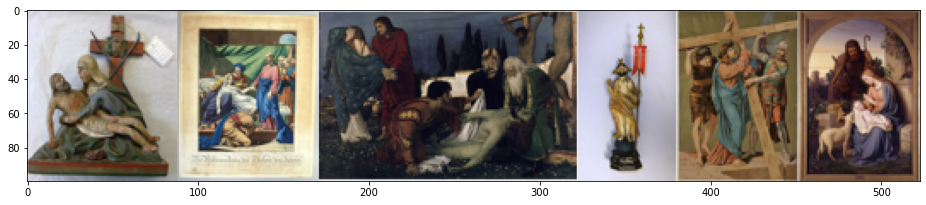

In [28]:
from keras.preprocessing import image

thumbs = []
for idx in idx_closest:
    img = image.load_img(paths[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


PCA reduction

Here we use PCA to boil down each feature vector to 512 values in order to use it later for UMAP and the features of the text

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)
pca.fit(embeds_norm)
pca_features = pca.transform(embeds_norm)
pca_features

array([[-8.81376283e-02,  1.65407874e-01, -1.72982940e-03, ...,
         1.29113732e-03, -5.69306519e-03,  1.27360462e-02],
       [ 4.86657687e-03,  2.90021995e-01, -9.90203179e-02, ...,
        -3.95516387e-03, -2.10504443e-03, -1.25742456e-03],
       [-2.11459584e-02,  3.53305031e-01,  4.44848976e-03, ...,
        -4.91999440e-03,  7.10395230e-04, -1.03923667e-04],
       ...,
       [ 1.56363493e-01, -1.15425368e-01, -1.18007739e-01, ...,
         1.01404916e-02,  1.47974884e-02, -9.11513683e-03],
       [-1.56291817e-01, -7.61285323e-02, -4.92994160e-03, ...,
         1.18557129e-02, -9.71818403e-03,  3.45262446e-03],
       [-1.74106939e-01, -9.29258453e-02, -1.24222670e-01, ...,
        -5.55856862e-03,  9.78962083e-04, -3.25230427e-03]])

In [31]:
def normalize_arr(arr):
  return tf.math.l2_normalize(tf.convert_to_tensor(arr, dtype=tf.float32), axis = 1).numpy()

In [32]:
pca_normed = normalize_arr(pca_features)
arr_to_csv(pca_normed, "pca-bit.csv")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,id
0,-1273,2390,-25,-5,2455,606,-853,671,788,955,-394,508,-270,990,-905,822,1611,1130,1187,151,-25,1771,175,-404,-1821,-726,-717,-462,2551,-435,-931,-289,-1235,2744,-184,1543,-429,-401,-282,663,...,32,-20,-91,-100,18,160,-49,129,215,21,-202,-84,-207,191,-321,-250,18,-7,-26,49,87,79,-79,-72,284,-153,-255,147,50,291,-255,110,-163,-237,-132,-85,19,-82,184,1486397
1,88,5223,-1783,-2574,148,134,746,-1133,-1854,950,-865,219,990,1760,1173,223,1555,650,1105,-49,-730,390,-972,-74,-11,-1870,-1099,17,-80,-144,447,-535,-371,-312,-763,-751,-922,-448,221,61,...,5,-12,6,214,66,13,-249,-20,-109,82,27,30,-106,-47,-65,-71,222,127,208,204,-58,-130,-242,-56,-297,-78,-22,-123,-55,29,-46,-48,-256,-266,-8,153,-71,-38,-23,1570538
2,-324,5407,68,-740,-379,-3315,-622,1065,636,-102,1019,4656,-389,-1885,-996,-964,-916,-427,-1056,417,-426,-365,1122,1682,-152,-250,-609,-276,-469,-419,-777,270,-896,-867,-844,-225,-134,308,-260,-213,...,18,-14,-3,223,21,-55,55,101,91,-88,7,-127,23,-33,-70,-227,115,-122,-2,-6,33,98,77,38,-6,-20,-32,-4,-9,83,-72,-147,18,138,103,-95,-75,11,-2,525580
3,1541,2094,-2471,3757,-984,-2047,-765,-371,-1737,-211,-895,-661,-268,444,1222,-265,-1312,-1940,-1560,-1667,-539,1505,-1245,-1090,-476,809,-399,256,-1234,1642,-63,-695,329,-336,-1053,252,629,650,48,-1408,...,-258,107,87,-71,13,-11,66,250,-54,-75,-232,68,280,-43,-104,65,-73,343,178,137,-210,110,37,54,67,77,-26,-30,337,105,108,16,32,-102,0,88,85,33,81,1442848
4,4258,-1770,3291,226,56,-469,471,-636,431,526,298,-128,-2375,-1599,1302,148,-361,685,1524,-240,-40,-746,-68,-1013,-328,-686,-730,571,-390,570,-91,751,-204,-291,1109,-209,-562,1682,-181,-505,...,165,-83,-108,120,-148,173,76,-37,-161,-239,86,-102,-78,-70,-7,206,-115,22,-207,-3,-71,107,25,125,4,-234,7,48,-59,85,-54,-97,-7,-84,91,210,-131,61,-3,962622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,-1260,4012,-57,-455,1769,-317,-2489,235,1137,-323,2198,2522,-328,-172,315,-83,898,-449,-1043,556,-117,-339,-1256,1262,-29,-181,981,-237,348,647,-263,479,-601,-2488,-1648,-1225,-1059,121,268,-411,...,-123,-131,81,215,145,-5,86,34,-93,-112,-199,-31,3,-207,-143,52,-15,-103,-51,-92,118,37,93,-95,-35,302,44,-205,95,-88,-33,41,52,176,100,231,11,-68,-104,984816
5136,-3379,130,-538,4124,1999,227,-727,-1413,-636,510,1543,-2000,-1053,-1656,-217,-496,-1954,-661,-747,141,185,-54,394,769,810,-80,-1402,54,-503,706,655,311,-523,-53,-221,1013,353,348,-449,-63,...,-178,-139,32,122,69,322,-108,164,76,128,22,21,162,-345,26,-196,-188,72,-116,59,78,184,-224,45,133,-29,-101,100,-145,-227,-40,-10,29,41,-126,47,52,381,-425,1479834
5137,2612,-1928,-1971,-2226,2003,361,503,-670,-2190,-841,783,685,791,787,278,732,-854,-1388,-1174,803,-155,-225,-962,-1720,-244,-1526,-345,159,119,-178,-658,-300,587,-268,1101,-297,345,465,590,287,...,-284,159,116,194,-233,-74,-202,126,154,216,169,-95,-15,-130,-55,208,75,133,-220,131,224,-72,95,-19,-227,-30,77,83,397,210,-232,-70,261,-151,88,-216,169,247,-152,961858
5138,-2302,-1121,-73,-2043,-1459,-1469,-1600,1084,2340,1562,-390,-2108,303,154,-1172,663,-81,699,-762,-447,622,154,-465,939,931,-1376,-325,1222,1042,-1446,-104,-804,1040,-911,-326,75,201,76,1809,-200,...,-340,119,84,-200,93,90,-247,-86,-43,-73,-249,-119,-47,-306,-61,-99,-68,25,-60,70,-282,-133,85,108,271,18,336,326,56,-158,-113,-103,32,-518,21,-52,175,-143,51,564288


In [33]:
np.inner(pca_normed, pca_normed)

array([[ 1.0000004 ,  0.16667879,  0.04975732, ..., -0.0818368 ,
         0.04209535, -0.01804438],
       [ 0.16667879,  1.0000002 ,  0.16767082, ...,  0.14139463,
        -0.07697573, -0.16532627],
       [ 0.04975732,  0.16767082,  1.0000004 , ..., -0.14500722,
        -0.06201395, -0.09642123],
       ...,
       [-0.0818368 ,  0.14139463, -0.14500722, ...,  1.        ,
        -0.08076411, -0.15223753],
       [ 0.04209535, -0.07697573, -0.06201395, ..., -0.08076411,
         0.9999998 , -0.10328756],
       [-0.01804438, -0.16532627, -0.09642123, ..., -0.15223753,
        -0.10328756,  0.99999976]], dtype=float32)

UMAP

In [65]:
import umap

umap_op = umap.UMAP(n_components=512)
umap_features = umap_op.fit_transform(embeds_norm)

In [66]:
umap_normed = normalize_arr(umap_features)
arr_to_csv(umap_normed, "umap-bit.csv")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,id
0,711,79,542,511,610,221,411,385,358,597,466,416,366,414,386,643,342,394,476,472,411,437,429,446,430,468,392,470,280,278,277,480,365,348,432,534,523,431,447,463,...,412,419,483,474,693,471,439,645,297,361,419,432,425,378,428,470,465,431,417,539,581,247,448,416,469,405,442,387,424,492,434,367,518,446,488,646,376,437,349,1486397
1,847,137,455,578,587,294,451,389,357,513,446,389,370,411,363,663,361,420,477,471,431,436,433,444,423,467,391,460,265,286,292,469,379,354,429,529,524,411,445,463,...,408,423,483,470,692,469,440,643,296,357,417,428,426,381,427,469,466,432,417,537,579,251,447,416,471,405,443,385,423,493,433,362,518,447,488,645,376,433,349,1570538
2,773,38,545,709,548,358,508,370,365,497,456,420,392,410,388,630,353,394,453,487,452,442,454,449,435,486,388,464,268,289,284,488,369,325,435,530,534,439,461,466,...,406,419,484,471,685,466,439,646,299,355,414,419,428,375,427,476,466,437,419,534,583,248,448,414,472,407,444,381,421,495,432,359,518,450,484,641,374,433,350,525580
3,833,215,427,563,596,355,452,387,352,510,441,400,365,411,373,669,357,420,478,472,431,443,432,438,430,466,388,461,262,290,294,473,380,353,432,527,519,414,440,461,...,407,423,484,469,691,468,439,645,297,357,417,425,426,382,427,471,465,433,417,536,580,251,448,417,472,405,443,384,423,493,434,361,518,447,488,645,376,433,349,1442848
4,1330,252,502,460,564,451,447,358,349,425,414,332,329,374,298,732,366,471,468,418,464,418,409,429,438,443,414,472,254,304,328,440,421,375,416,475,523,359,430,461,...,399,424,479,463,697,473,440,652,298,353,422,428,420,390,424,466,459,425,410,532,569,248,454,418,477,398,436,374,419,486,433,366,522,437,488,646,377,429,346,962622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,750,139,502,566,594,284,431,417,351,560,455,407,372,413,380,650,350,401,479,476,422,445,431,443,428,472,388,466,271,285,285,480,370,347,432,536,525,428,445,464,...,409,420,483,472,691,469,439,644,297,358,417,428,425,379,428,471,465,432,418,537,581,249,448,416,470,405,443,385,423,493,433,364,517,448,488,644,376,435,350,984816
5136,698,271,436,506,607,337,409,417,341,569,452,421,365,418,393,662,345,405,489,477,415,452,428,432,433,468,382,466,269,287,287,482,371,352,437,538,512,429,434,459,...,409,420,484,471,692,469,438,645,296,358,417,427,425,381,428,472,466,433,418,537,583,250,448,417,470,406,443,386,424,492,435,364,518,447,488,644,377,435,350,1479834
5137,1328,407,271,549,570,500,438,385,356,405,375,334,327,415,318,733,409,476,484,470,464,432,417,439,421,433,388,424,236,312,332,441,418,374,426,492,506,360,424,457,...,399,425,482,462,688,461,440,642,295,355,416,427,422,391,425,467,459,429,412,535,571,252,446,420,470,400,441,379,420,489,437,355,514,440,484,643,372,425,343,961858
5138,470,192,484,556,542,303,474,294,347,587,485,473,389,424,431,625,335,393,481,491,413,442,456,430,435,480,383,472,279,264,269,489,348,332,439,554,509,452,445,462,...,415,417,482,474,691,470,440,643,294,360,415,430,429,381,428,477,467,437,419,537,590,249,449,415,469,407,445,388,431,496,433,363,518,447,483,645,375,443,350,564288


In [49]:
np.inner(umap_normed, umap_normed)

array([[1.        , 0.9996971 , 0.9994001 , ..., 0.996112  , 0.9994128 ,
        0.9989548 ],
       [0.9996971 , 1.        , 0.9996345 , ..., 0.99770486, 0.99891126,
        0.9987378 ],
       [0.9994001 , 0.9996345 , 0.9999999 , ..., 0.9964261 , 0.99891216,
        0.9981597 ],
       ...,
       [0.996112  , 0.99770486, 0.9964261 , ..., 1.        , 0.99427474,
        0.9955302 ],
       [0.9994128 , 0.99891126, 0.99891216, ..., 0.99427474, 1.        ,
        0.99927676],
       [0.9989548 , 0.9987378 , 0.9981597 , ..., 0.9955302 , 0.99927676,
        1.0000004 ]], dtype=float32)

Visualize the results

In [60]:
import altair as alt

def plot(df):
  alt.data_transformers.disable_max_rows()
  return alt.Chart(df).encode(
        x='x',
        y='y',
        tooltip=['id']
    ).mark_circle(size=60).properties(
        width=600, height=600
    ).interactive()

reduce the 512 vector long UMAP projection to a 2D projection

In [67]:
umap_op = umap.UMAP(n_components=2)
umap_umap_2d = umap_op.fit_transform(umap_normed)
umap_umap_2d_df = pd.DataFrame(data=umap_umap_2d, columns=['x', 'y'])
umap_umap_2d_df['id'] = ids
umap_umap_2d_df.to_csv("umap-2d-bit.csv")

In [69]:
plot(umap_umap_2d_df)

alt.Chart(...)

reduce the 512 vector long PCA projection to a 2D projection

In [62]:
umap_op = umap.UMAP(n_components=2)
umap_pca_2d = umap_op.fit_transform(pca_normed)
umap_pca_2d_df = pd.DataFrame(data=umap_pca_2d, columns=['x', 'y'])
umap_pca_2d_df['id'] = ids
umap_pca_2d_df.to_csv("pca-2d-bit.csv")

In [63]:
plot(umap_pca_2d_df)

alt.Chart(...)

TEST Model performance


---



In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  #resized = tf.image.resize(img, [299,299], antialias=True)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return converted_img

In [ ]:
img = load_img("/content/crop/ang/961918.jpg")
embed = model_b(img)
#np.array(img).shape
#converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

In [ ]:
tf.squeeze(embed)

<tf.Tensor: shape=(8192,), dtype=float32, numpy=
array([0.00215117, 0.        , 0.00160996, ..., 0.05892634, 0.79840714,
       0.        ], dtype=float32)>

In [ ]:
%time embed = model_b(img)

CPU times: user 103 ms, sys: 67.3 ms, total: 171 ms
Wall time: 172 ms


In [ ]:
%time embed = model_b(img)

CPU times: user 341 ms, sys: 279 ms, total: 620 ms
Wall time: 621 ms


In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  pil_image = Image.open(image_data)
#  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
#  pil_image_rgb = pil_image.convert("RGB")